## Final Project Submission¶

Student name: Eduardo Osorio

Student pace: part time 

Scheduled project review date/time:

Instructor name: Yish Lim

Blog post URL:

## Log transform and dummy variables
- We log transformed to make the data less skewed

- created dummy variables before running train-test split

In [1]:
import pandas as pd
import numpy as np


kcc = pd.read_csv('data_files/kc_cleaned.csv')

continuous = ['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'yr_built']
categoricals = ['bedrooms', 'floors', 'waterfront', 'grade', 'condition', 'yrs_renovated', 'sale_month']

kcc_cont = kcc[continuous]

# log features
log_names = [f'{column}_log' for column in kcc_cont.columns]

kcc_log = np.log(kcc_cont)
kcc_log.columns = log_names

# normalize (subract mean and divide by std)

# def normalize(feature):
#     return (feature - feature.mean()) / feature.std()

# kcc_log_norm = kcc_log.apply(normalize)

# one hot encode categoricals
kcc_ohe = pd.get_dummies(kcc[categoricals], columns=['bedrooms', 'floors', 'waterfront', 'grade', 'condition', 'yrs_renovated', 'sale_month'], drop_first=True)

preprocessed = pd.concat([kcc_log, kcc_ohe], axis=1)

## Stepwise Function
- using a stwepwise funtion with backwards elimination to drop p-values over .05

In [2]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, # Pvals over .05 are dropped
                       verbose=True):
 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) #Adding pvals under the threshold

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval)) #drops pvals over thershold
        if not changed:
            break
    return included

## Train-Test Split
- Using train test split to make sample size of 20 % 

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = preprocessed.drop('price_log', axis=1)
y = preprocessed['price_log']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Using a test size of 20%

## Running the stepwise
- Ran the stepwise function on the X_train and y_train  to eliminate p-values over .05

In [6]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)
#Feed x_train and Y_train into the stepwise function

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Add  sqft_living15_log              with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  yr_built_log                   with p-value 3.18e-229
Add  sqft_lot_log                   with p-value 8.90312e-168
Add  grade_10                       with p-value 1.04022e-98
Add  grade_9                        with p-value 1.40092e-101
Add  grade_11                       with p-value 3.71945e-150
Add  grade_8                        with p-value 7.88849e-152
Add  grade_12                       with p-value 2.04783e-151
Add  grade_7                        with p-value 1.13557e-103
Add  waterfront_1.0                 with p-value 4.59242e-77
Add  grade_13                       with p-value 1.59985e-68
Add  floors_3.0                     with p-value 6.56202e-40
Add  bedrooms_2                     with p-value 8.93238e-38
Add  condition_5                    with p-value 1.37872e-20
Add  sale_month_4                   with p-value 2.41104e-14
Add  grade_6                        

## OLS

In [7]:
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     1019.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:01:45   Log-Likelihood:                -3684.0
No. Observations:               15372   AIC:                             7428.
Df Residuals:                   15342   BIC:                             7657.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 87.9413      1.804     48.756      0.000      84.406      91.477
sqft_living15_log      0.2692      0.013     21.395      0.000       0.245       0.294
sqft_living_log        0.4385      0.011     38.808      0.000       0.416       0.461
yr_built_log         -10.5857      0.238    -44.454      0.000     -11.052     -10.119
sqft_lot_log          -0.0579      0.003    -17.218      0.000      -0.065      -0.051
grade_10               1.0412      0.029     36.320      0.000       0.985       1.097
grade_9                0.8408      0.027     31.554      0.000       0.789       0.893
grade_11               1.2308      0.033     36.778      0.000       1.165       1.296
grade_8                0.5974      0.025     23.867      0.000       0.548       0.646
grade_12               1.4979      0.048     30.914      0.000       1.403       1.593
grade_7                0.3926      0.024     16.398      0.000       0.346       0.440
waterfront_1.0         0.5501      0.030     18.194      0.000       0.491       0.609
grade_13               1.8447      0.102     18.054      0.000       1.644       2.045
floors_3.0             0.2432      0.017     14.213      0.000       0.210       0.277
bedrooms_2             0.1105      0.009     12.822      0.000       0.094       0.127
condition_5            0.1047      0.010     10.581      0.000       0.085       0.124
sale_month_4           0.0702      0.008      8.512      0.000       0.054       0.086
grade_6                0.1656      0.024      6.831      0.000       0.118       0.213
bedrooms_4            -0.0323      0.006     -5.461      0.000      -0.044      -0.021
condition_2           -0.1296      0.028     -4.564      0.000      -0.185      -0.074
sale_month_3           0.0477      0.009      5.281      0.000       0.030       0.065
floors_2.0             0.0347      0.007      4.815      0.000       0.021       0.049
condition_4            0.0239      0.006      3.841      0.000       0.012       0.036
yrs_renovated_66.0     0.9888      0.308      3.209      0.001       0.385       1.593
floors_1.5             0.0335      0.010      3.465      0.001       0.015       0.052
yrs_renovated_13.0     0.2178      0.073      2.992      0.003       0.075       0.361
floors_2.5             0.0855      0.029      2.948      0.003       0.029       0.142
yrs_renovated_10.0     0.2743      0.093      2.950      0.003       0.092       0.457
yrs_renovated_14.0     0.2088      0.077      2.707      0.007       0.058       0.360
sale_month_5           0.0205      0.008      2.585      0.010       0.005       0.036
==============================================================================
Omnibus:                       59.545   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (J

## Recursive Feature Elimination
- Using skitlearns REF algorithm to select the most relevant features fo us
- in this case, were using all the future since our r squared is lower then what I wanted

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 46)
selector = selector.fit(X_fin, y_train.values.ravel()) 
selector.support_ 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [9]:
selected_columns = X_fin.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
selected_columns

Index(['sqft_living15_log', 'sqft_living_log', 'yr_built_log', 'sqft_lot_log',
       'grade_10', 'grade_9', 'grade_11', 'grade_8', 'grade_12', 'grade_7',
       'waterfront_1.0', 'grade_13', 'floors_3.0', 'bedrooms_2', 'condition_5',
       'sale_month_4', 'grade_6', 'bedrooms_4', 'condition_2', 'sale_month_3',
       'floors_2.0', 'condition_4', 'yrs_renovated_66.0', 'floors_1.5',
       'yrs_renovated_13.0', 'floors_2.5', 'yrs_renovated_10.0',
       'yrs_renovated_14.0', 'sale_month_5'],
      dtype='object')

## R Squared and MSE
- Here are is the R squared and Mean Squared error for both the Test and Train

In [11]:
y_hat_train = linreg.predict(X_fin[selected_columns])
y_hat_test = linreg.predict(X_test[selected_columns])

In [12]:
linreg.score(X_fin[selected_columns], y_train)

0.6583203620874299

In [13]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.09455605227647854
Test Mean Squarred Error: 0.09261991835487239


In [14]:
# from sklearn.linear_model import LinearRegression
# linreg = LinearRegression()

# linreg.fit(X_train, y_train)
# y_hat_test = linreg.predict(X_test)

In [15]:
# from sklearn.metrics import mean_squared_error
# test_residuals = y_hat_test - y_test

# test_mse = mean_squared_error(y_test, y_hat_test)
# test_mse

## Un-Logging
- Since we log transformed at the begining we also need to un-log to get an accurate standard error

In [16]:
train_error_log = np.sqrt(mse_train)
test_error_log = np.sqrt(mse_test)
print(train_error_log)
print(test_error_log)

0.307499678498171
0.3043352072220242


In [17]:
train_error = np.exp(train_error_log)
test_error = np.exp(test_error_log)
print('train error:',train_error)
print('test error:', test_error)

train error: 1.3600203712528536
test error: 1.3557234282152133


## Checking  the QQ plot and Homoscedasticity
- 

In [18]:
import scipy.stats as stats

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

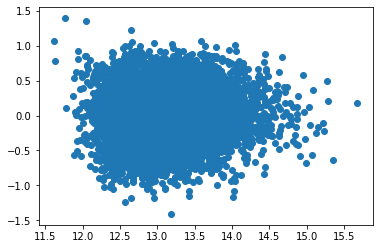

In [20]:
plt.scatter(y_hat_train, model.resid)
# plt.plot(y_hat_train(X_train[selected_columns])

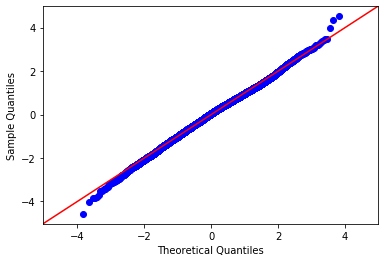

In [21]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Testing for Multicollinearity

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = X_fin
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X_fin, vif))

[('sqft_living15_log', 1462.1531882738877),
 ('sqft_living_log', 1182.1511761593626),
 ('yr_built_log', 1393.2124335789533),
 ('sqft_lot_log', 148.9809843137723),
 ('grade_10', 6.935748090789837),
 ('grade_9', 13.711251085080963),
 ('grade_11', 3.1889215929095345),
 ('grade_8', 28.380480126201796),
 ('grade_12', 1.5526105488106856),
 ('grade_7', 38.15877389928284),
 ('waterfront_1.0', 1.029862362725363),
 ('grade_13', 1.1013402244879626),
 ('floors_3.0', 1.320289381808536),
 ('bedrooms_2', 1.5024571261822675),
 ('condition_5', 1.2017003088605462),
 ('sale_month_4', 1.1532945276225646),
 ('grade_6', 9.045519934099735),
 ('bedrooms_4', 1.8072839273163719),
 ('condition_2', 1.034887373368598),
 ('sale_month_3', 1.124731650802968),
 ('floors_2.0', 2.857304677161124),
 ('condition_4', 1.582970139062787),
 ('yrs_renovated_66.0', 1.0015828039921568),
 ('floors_1.5', 1.23340493382698),
 ('yrs_renovated_13.0', 1.0054099353049324),
 ('floors_2.5', 1.0658530885487578),
 ('yrs_renovated_10.0', 1.0

- Some of the features are displaying multicollinearity but droping them would lower the r squared even lower then it already is.

In [23]:
X_fin = X_test[selected_columns]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_test,X_with_intercept).fit()
model.summary()

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     282.6
Date:                Sat, 31 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:01:47   Log-Likelihood:                -875.07
No. Observations:                3844   AIC:                             1808.
Df Residuals:                    3815   BIC:                             1990.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 85.4455      3.585     23.837      0.000      78.418      92.473
sqft_living15_log      0.2502      0.025     10.117      0.000       0.202       0.299
sqft_living_log        0.4491      0.022     20.121      0.000       0.405       0.493
yr_built_log         -10.2420      0.474    -21.628      0.000     -11.170      -9.314
sqft_lot_log          -0.0568      0.007     -8.609      0.000      -0.070      -0.044
grade_10               1.0042      0.055     18.399      0.000       0.897       1.111
grade_9                0.7792      0.050     15.442      0.000       0.680       0.878
grade_11               1.2017      0.062     19.409      0.000       1.080       1.323
grade_8                0.5463      0.047     11.658      0.000       0.454       0.638
grade_12               1.5047      0.089     16.895      0.000       1.330       1.679
grade_7                0.3305      0.045      7.417      0.000       0.243       0.418
waterfront_1.0         0.5612      0.051     11.064      0.000       0.462       0.661
grade_13               1.8173      0.187      9.743      0.000       1.452       2.183
floors_3.0             0.2327      0.037      6.341      0.000       0.161       0.305
bedrooms_2             0.1087      0.017      6.326      0.000       0.075       0.142
condition_5            0.1190      0.020      5.864      0.000       0.079       0.159
sale_month_4           0.0855      0.017      5.134      0.000       0.053       0.118
grade_6                0.1223      0.045      2.692      0.007       0.033       0.211
bedrooms_4            -0.0268      0.012     -2.313      0.021      -0.049      -0.004
condition_2           -0.1712      0.057     -3.025      0.003      -0.282      -0.060
sale_month_3           0.0469      0.017      2.711      0.007       0.013       0.081
floors_2.0             0.0162      0.014      1.142      0.254      -0.012       0.044
condition_4            0.0266      0.012      2.157      0.031       0.002       0.051
yrs_renovated_66.0  2.058e-14   2.09e-15      9.834      0.000    1.65e-14    2.47e-14
floors_1.5             0.0240      0.020      1.184      0.236      -0.016       0.064
yrs_renovated_13.0     0.1609      0.125      1.287      0.198      -0.084       0.406
floors_2.5             0.0128      0.063      0.203      0.839      -0.111       0.136
yrs_renovated_10.0     0.2182      0.176      1.236      0.216      -0.128       0.564
yrs_renovated_14.0     0.0066      0.218      0.030      0.976      -0.421       0.434
sale_month_5           0.0320      0.016      1.946      0.052      -0.000       0.064
==============================================================================
Omnibus:                       14.230   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.001   Jarque-Bera (J

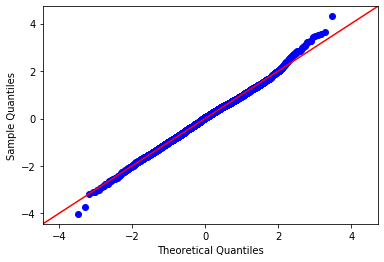

In [24]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

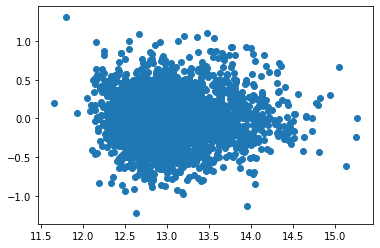

In [25]:
plt.scatter(y_hat_test, model.resid)